# 1000 Genomes Variant Enrichment Analysis

This notebook downloads chromosome 22 VCF data from the 1000 Genomes Project,
extracts the first 10,000 variants, and performs a Chi-square test to evaluate
if any variants are significantly enriched in allele frequency in one continental
population versus others.

In [1]:
# Install necessary packages
!pip install cyvcf2 pandas scipy tqdm seaborn --quiet

In [2]:
from cyvcf2 import VCF
import pandas as pd
from scipy.stats import chi2_contingency
from tqdm import tqdm
import os, gzip, shutil

# Download VCF for chromosome 22
#vcf_url = "https://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/ALL.chr22.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz"
#vcf_file = "ALL.chr22.phase3_shapeit2.vcf.gz"

## Download the subsetted file for efficiency
vcf_url = "https://github.com/schatzlab/ncpi_crc/raw/refs/heads/main/data/HEAD15000.ALL.chr22.phase3_shapeit2_mvncall_integrated_v5b.20130502.genotypes.vcf.gz"
vcf_file = "chr22.genotypes.vcf.gz"

if not os.path.exists(vcf_file):
    !wget -O {vcf_file} {vcf_url}

In [3]:
# Load population metadata
sample_info_url = "ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/technical/working/20130606_sample_info/20130606_sample_info.txt"
sample_info_file = "20130606_sample_info.txt"

if not os.path.exists(sample_info_file):
    !wget -O {sample_info_file} {sample_info_url}

In [4]:
sample_df = pd.read_csv(sample_info_file, sep='\t')

# Population-to-superpopulation map (from 1000 Genomes documentation)
pop_to_super = {
    'ACB': 'AFR', 'ASW': 'AFR', 'ESN': 'AFR', 'GWD': 'AFR', 'LWK': 'AFR',
    'MSL': 'AFR', 'YRI': 'AFR',
    'CEU': 'EUR', 'FIN': 'EUR', 'GBR': 'EUR', 'IBS': 'EUR', 'TSI': 'EUR',
    'CHB': 'EAS', 'CHS': 'EAS', 'CDX': 'EAS', 'KHV': 'EAS', 'JPT': 'EAS',
    'BEB': 'SAS', 'GIH': 'SAS', 'ITU': 'SAS', 'PJL': 'SAS', 'STU': 'SAS',
    'CLM': 'AMR', 'MXL': 'AMR', 'PEL': 'AMR', 'PUR': 'AMR'
}

# Now map each sample to its superpopulation
sample_df['Superpopulation'] = sample_df['Population'].map(pop_to_super)

# Build the sample-to-superpopulation dictionary
pop_map = sample_df.set_index('Sample')['Superpopulation'].dropna().to_dict()
print (sample_df['Superpopulation'].value_counts())

print("Total samples: ", sum(sample_df['Superpopulation'].value_counts()))


Superpopulation
AFR    1018
EUR     669
SAS     661
EAS     617
AMR     535
Name: count, dtype: int64
Total samples:  3500


In [42]:
from cyvcf2 import VCF
from collections import defaultdict
from scipy.stats import fisher_exact
import numpy as np

vcf = VCF(vcf_file)
samples = vcf.samples
sample_pops = [pop_map.get(s, None) for s in samples]
pop_set = sorted(set([p for p in sample_pops if p]))

sig_variants = defaultdict(list)
max_variants = 10000
pval_threshold = 0.05

# Process the VCF file
for i, variant in enumerate(vcf):
    if i >= max_variants:
        break

    genos = variant.genotypes
    if not genos:
        continue

    pop_alleles = {p: [0, 0] for p in pop_set}
    for geno, pop in zip(genos, sample_pops):
        if pop not in pop_alleles or geno[0] == -1 or geno[1] == -1:
            continue

        # Count alternative alleles (0 = reference, 1+ = alternative)
        alt = sum(1 for allele in geno[:2] if allele > 0)
        ref = 2 - alt

        # Ensure we don't get negative counts
        if alt < 0 or ref < 0 or alt > 2 or ref > 2:
            continue

        pop_alleles[pop][0] += alt
        pop_alleles[pop][1] += ref

    for p in pop_set:
        alt_p, ref_p = pop_alleles[p]
        if alt_p + ref_p < 10 or alt_p < 0 or ref_p < 0:
            continue

        # Test this population against EACH other population individually
        pvals = []
        af_target = alt_p / (alt_p + ref_p)
        valid_comparisons = 0
        min_af_diff = float('inf')
        
        for other in [x for x in pop_set if x != p]:
            alt_o, ref_o = pop_alleles[other]
            if alt_o + ref_o < 10 or alt_o < 0 or ref_o < 0:
                continue
                
            # Fisher's exact test for this pair
            table = [[alt_p, ref_p], [alt_o, ref_o]]
            _, pval = fisher_exact(table)
            pvals.append(pval)
            
            # Track the minimum allele frequency difference
            af_other = alt_o / (alt_o + ref_o)
            af_diff = abs(af_target - af_other)
            min_af_diff = min(min_af_diff, af_diff)
            
            valid_comparisons += 1

        # Require at least 2 valid comparisons
        if valid_comparisons < 2 or not pvals:
            continue
            
        # ALL comparisons must be significant
        all_significant = all(pval <= pval_threshold for pval in pvals)
        if not all_significant:
            continue

        # Require that the target population differs from ALL others by at least 10%
        if min_af_diff < 0.10:
            continue
            
        # Use the maximum p-value (least significant) as the reported p-value
        max_pval = max(pvals)

        # Handle zero p-values (very significant results)
        if max_pval == 0:
            neglog10p = 50
        else:
            neglog10p = -np.log10(max_pval)

        afs = {pop: round(pop_alleles[pop][0] / (pop_alleles[pop][0] + pop_alleles[pop][1] + 1e-8), 4) for pop in pop_set}
        allele_counts = {pop: (pop_alleles[pop][0], pop_alleles[pop][1]) for pop in pop_set}
        af_target = afs[p]
        af_others = [afs[x] for x in pop_set if x != p]
        af_closest = min(af_others, key=lambda af: abs(af - af_target))
        if af_closest == 0 or af_target == 0:
            continue
        log2fc = np.log2(af_target / af_closest)

        sig_variants[p].append({
            'variant': variant.ID or f"{variant.CHROM}:{variant.POS}",
            'pvalue': f"{max_pval:.3e}",
            'log2fc': log2fc,
            'neglog10p': neglog10p,
            'allele_freqs': afs,
            'allele_counts': allele_counts
        })

In [43]:
# Create sig_counts from sig_variants
sig_counts = {pop: len(variants) for pop, variants in sig_variants.items()}

# Summary table
summary_df = pd.DataFrame.from_dict(sig_counts, orient='index', columns=['Significant Variants'])
summary_df = summary_df.sort_values(by='Significant Variants', ascending=False)
print(summary_df)
print("Total across all populations:", summary_df['Significant Variants'].sum())


     Significant Variants
AFR                   248
EAS                    80
SAS                    43
EUR                    10
AMR                     2
Total across all populations: 383


In [44]:
import csv

output_dir = "enrichment_results/sig_variants"
os.makedirs(output_dir, exist_ok=True)

for pop, entries in sig_variants.items():
    output_file = os.path.join(output_dir, f"{pop}_significant_variants.csv")
    with open(output_file, "w", newline="") as f:
        writer = csv.writer(f)
        # Header row: Variant, p-value, AF_EUR, AF_AFR, ..., AC_EUR, RC_EUR, ...
        af_headers = [f"AF_{p}" for p in pop_set]
        ac_headers = [f"AC_{p}" for p in pop_set]
        rc_headers = [f"RC_{p}" for p in pop_set]
        header = ["Variant", "p-value"] + af_headers + ac_headers + rc_headers
        writer.writerow(header)
        for entry in entries:
            af_row = [entry["allele_freqs"][p] for p in pop_set]
            ac_row = [entry["allele_counts"][p][0] for p in pop_set]
            rc_row = [entry["allele_counts"][p][1] for p in pop_set]
            row = [entry["variant"], entry["pvalue"]] + af_row + ac_row + rc_row
            writer.writerow(row)


In [39]:
!head -n 3 enrichment_results/sig_variants/AFR_significant_variants.csv
!head -n 3 enrichment_results/sig_variants/EUR_significant_variants.csv
!head -n 3 enrichment_results/sig_variants/EAS_significant_variants.csv
!head -n 3 enrichment_results/sig_variants/SAS_significant_variants.csv
!head -n 3 enrichment_results/sig_variants/AMR_significant_variants.csv

Variant,p-value,AF_AFR,AF_AMR,AF_EAS,AF_EUR,AF_SAS
22:16058766,8.445e-13,0.1377,0.3285,0.4107,0.2555,0.2679
22:16058767,8.445e-13,0.1377,0.3285,0.4107,0.2555,0.2679
Variant,p-value,AF_AFR,AF_AMR,AF_EAS,AF_EUR,AF_SAS
22:16053659,5.382e-07,0.8994,0.8329,0.9167,0.7296,0.8896
22:16058883,2.433e-07,0.4425,0.6816,0.8502,0.5567,0.7955
Variant,p-value,AF_AFR,AF_AMR,AF_EAS,AF_EUR,AF_SAS
22:16053659,5.382e-07,0.8994,0.8329,0.9167,0.7296,0.8896
22:16058883,2.433e-07,0.4425,0.6816,0.8502,0.5567,0.7955
Variant,p-value,AF_AFR,AF_AMR,AF_EAS,AF_EUR,AF_SAS
22:16052167,2.191e-06,0.357,0.5548,0.6687,0.3698,0.4744
22:16067462,9.479e-06,0.2027,0.3732,0.4821,0.2376,0.274
Variant,p-value,AF_AFR,AF_AMR,AF_EAS,AF_EUR,AF_SAS
22:16052167,2.191e-06,0.357,0.5548,0.6687,0.3698,0.4744
22:16067462,9.479e-06,0.2027,0.3732,0.4821,0.2376,0.274
Variant,p-value,AF_AFR,AF_AMR,AF_EAS,AF_EUR,AF_SAS
22:16051249,6.547e-11,0.0038,0.1455,0.0893,0.0934,0.2791
22:16051453,7.894e-12,0.003,0.1239,0.0744,0.0775,0.2577
Variant,p-value

In [45]:
from scipy.stats import fisher_exact

# AMR vs AFR
table = [[473, 221], [585, 737]]
_, pval_amr_afr = fisher_exact(table)

# AMR vs EAS
table = [[473, 221], [857, 151]]
_, pval_amr_eas = fisher_exact(table)

# AMR vs EUR
table = [[473, 221], [560, 446]]
_, pval_amr_eur = fisher_exact(table)

# AMR vs SAS
table = [[473, 221], [778, 200]]
_, pval_amr_sas = fisher_exact(table)

print(pval_amr_afr, pval_amr_eas, pval_amr_eur, pval_amr_sas)

7.964703909380755e-25 2.5663170080294e-16 2.4334288609581446e-07 1.7933166629609994e-07


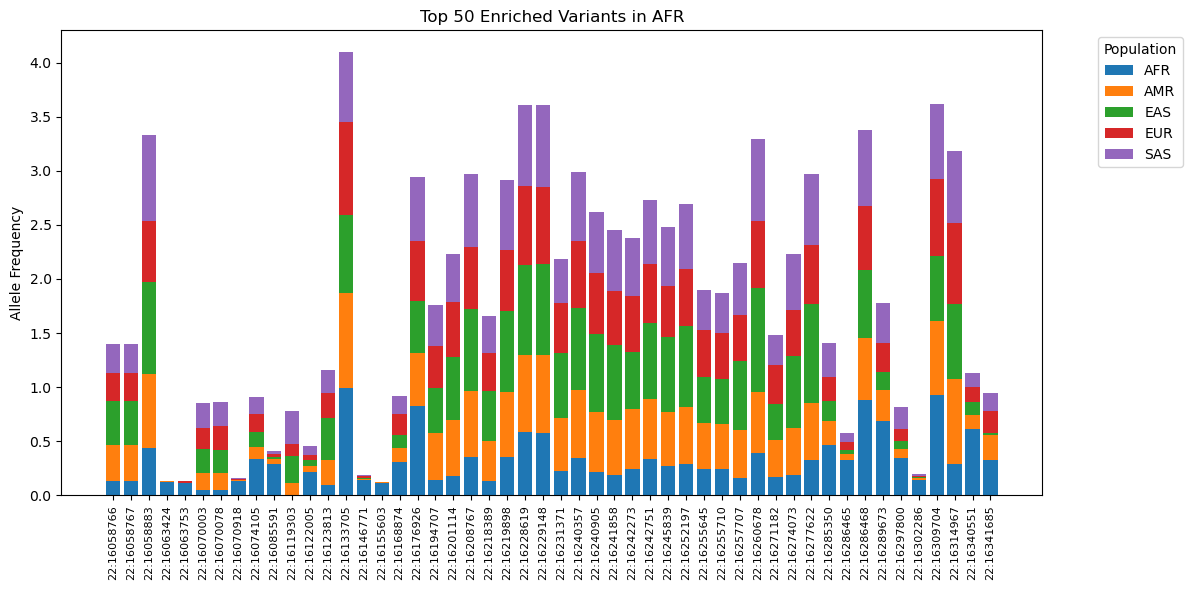

In [48]:
import matplotlib.pyplot as plt
import pandas as pd

# Verify that sig_variants exists
if 'sig_variants' not in globals():
    raise RuntimeError("You must run the enrichment analysis first to generate 'sig_variants'.")

# Parameters
target_pop = "AFR"
top_n = 50
colors = {
    "AFR": "#1f77b4",
    "AMR": "#ff7f0e",
    "EAS": "#2ca02c",
    "EUR": "#d62728",
    "SAS": "#9467bd"
}

# Extract top variants
top_variants = sig_variants[target_pop][:top_n]

# Prepare data for stacked bar chart
variant_ids = [v["variant"] for v in top_variants]
populations = sorted(pop_set, key=lambda x: (x != target_pop, x))  # target pop first
data = {pop: [] for pop in populations}

for v in top_variants:
    for pop in populations:
        data[pop].append(v["allele_freqs"].get(pop, 0))

df = pd.DataFrame(data, index=variant_ids)

# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(12, 6))
bottom = [0] * len(df)

for pop in populations:
    ax.bar(df.index, df[pop], bottom=bottom, label=pop, color=colors.get(pop, None))
    bottom = [i + j for i, j in zip(bottom, df[pop])]

ax.set_ylabel("Allele Frequency")
ax.set_title(f"Top {top_n} Enriched Variants in {target_pop}")
ax.set_xticks(range(len(df)))
ax.set_xticklabels(df.index, rotation=90, fontsize=8)
ax.legend(title="Population", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


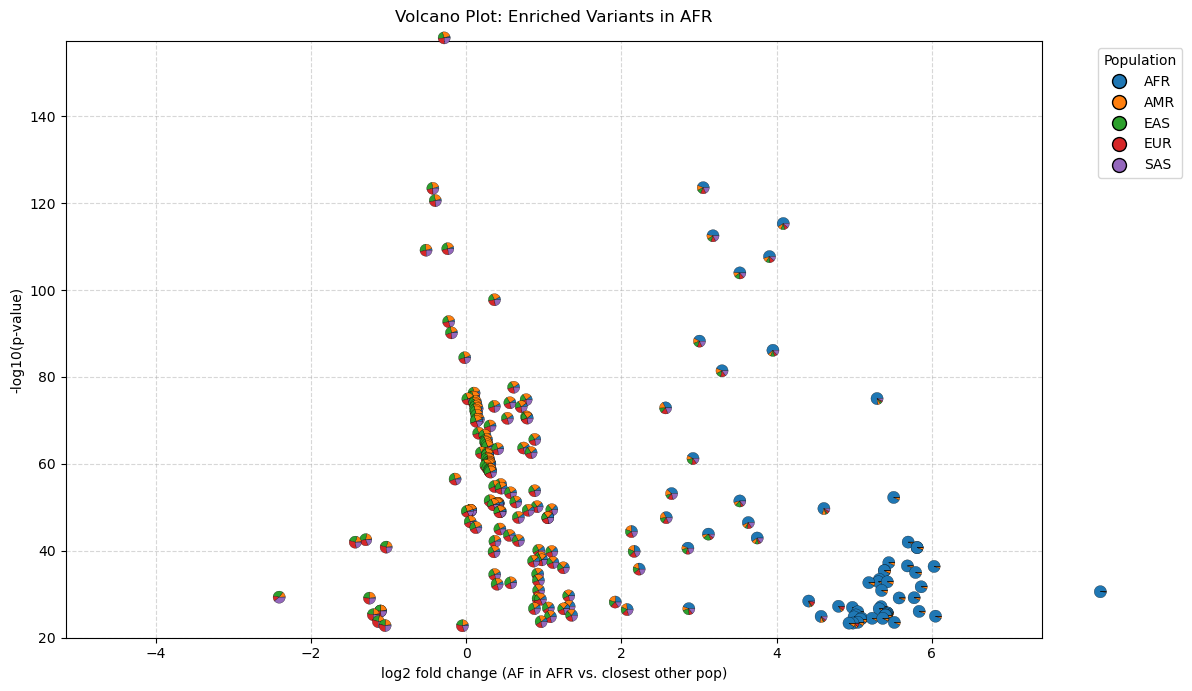

In [47]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# Target population
target_pop = "AFR"

# Color map
color_map = {
    "AFR": "#1f77b4",
    "AMR": "#ff7f0e",
    "EAS": "#2ca02c",
    "EUR": "#d62728",
    "SAS": "#9467bd"
}

# Collect volcano data
plot_data = []
for entry in sig_variants[target_pop]:
    af_target = entry["allele_freqs"][target_pop]
    afs_other = {pop: entry["allele_freqs"][pop] for pop in pop_set if pop != target_pop}
    closest_pop = min(afs_other.keys(), key=lambda p: abs(afs_other[p] - af_target))
    af_closest = afs_other[closest_pop]
    if af_closest == 0:
        log2fc = 50  # Use a large value for log2fc if closest AF is zero
    else:
        log2fc = np.log2(af_target / af_closest)
    neglog10p = -np.log10(float(entry["pvalue"]))
    plot_data.append({
        "variant": entry["variant"],
        "log2fc": log2fc,
        "neglog10p": neglog10p,
        "allele_freqs": entry["allele_freqs"]
    })

# Top 200 most significant
plot_data = sorted(plot_data, key=lambda x: -x["neglog10p"])[:200]

# Create figure
fig, ax = plt.subplots(figsize=(12, 7))
ax.set_xlabel(f"log2 fold change (AF in {target_pop} vs. closest other pop)")
ax.set_ylabel("-log10(p-value)")
ax.set_title(f"Volcano Plot: Enriched Variants in {target_pop}")
ax.grid(True, linestyle="--", alpha=0.5)

# Determine bounds
xvals = [d["log2fc"] for d in plot_data]
yvals = [d["neglog10p"] for d in plot_data]
xpad = 1
ypad = 1
ax.set_xlim(min(xvals) - xpad, max(xvals) + xpad)
ax.set_ylim(min(yvals) - ypad, max(yvals) + ypad)

# Function to draw a pie at a data point
def draw_pie(ax, x, y, freqs, size=0.05):
    inset_ax = ax.inset_axes([x, y, size, size], transform=ax.transData)
    inset_ax.pie([freqs[p] for p in sorted(freqs)], 
                 colors=[color_map[p] for p in sorted(freqs)],
                 wedgeprops={"edgecolor": "k", "linewidth": 0.2})
    inset_ax.set_aspect("equal")
    inset_ax.axis("off")

# Draw all pies
for d in plot_data:
    draw_pie(ax, d["log2fc"], d["neglog10p"], d["allele_freqs"], size=3.5)

# Add legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=pop,
           markerfacecolor=color_map[pop], markersize=10, markeredgecolor='k')
    for pop in sorted(color_map)
]
ax.legend(handles=legend_elements, title="Population", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()